## softmax回归，从零开始实现

In [1]:
import torch
import sys
sys.path.append('..')
import utils
import d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', 4)

### 1.初始化模型参数

- 展平每个图象（丢失空间信息）
- 因为有10个类别，所以网络的输出维度为10

In [2]:
num_inputs = 28 * 28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 2.定义softmax操作

回顾降维

In [3]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

待操作的是一个(batch_size, num_outputs)的矩阵，需要按行向量求softmax
$$
softmax(X)_{i,j} = \frac{exp(X_{i,j})}{\sum_k exp(X_{i,k})}
$$

In [4]:
def softmax(X):
    X_exp = torch.exp(X)    # 按元素
    partition = X_exp.sum(1, keepdim=True)  # 行和，压缩dim1
    return X_exp / partition    # 广播机制

注意，这里是粗糙的，没有防止数值的上溢或下溢！

In [5]:
# 验证
X = torch.normal(0, 1, (2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2643, 0.0970, 0.3157, 0.1491, 0.1740],
         [0.0412, 0.7403, 0.0241, 0.0256, 0.1688]]),
 tensor([1.0000, 1.0000]))

### 3.实现softmax模型

定义模型

In [6]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)  # X从(batch_size, 1, 28, 28)四维，变成(batch_size, 28*28)二维

损失函数：y为类别，大小为batch_size的一维向量，元素为整数，代表第几类

回顾索引方式，取了(0,0)和(1,2)，取出来后变成向量

In [25]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [8]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

评估函数

In [9]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [10]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的预测准确率"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = utils.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)   # 刚随机初始化后的参数，正确率相当于瞎猜

0.0428

### 4.训练

In [11]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = utils.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()              # loss返回的是一个大小为batch_size的向量
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回本epoch的平均训练损失和平均训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [12]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # 逐个epoch迭代
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)     # 训练一个epoch
        test_acc = evaluate_accuracy(net, test_iter)                        # 评估测试集上的分类准确率
        animator.add(epoch + 1, train_metrics + (test_acc,))                # 这里的+是list合并，最后相当于[train_loss, train_acc, test_acc]
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

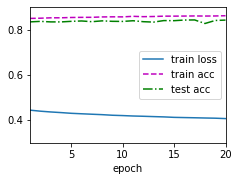

In [14]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 20
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 5.评估

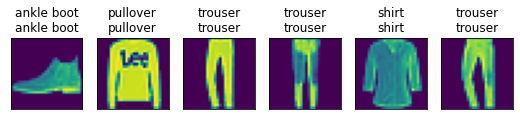

In [15]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

### 6.小结

- 借助softmax回归，我们可以训练多分类的模型。
- 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

### 7.练习

- 在本节中，我们直接实现了基于数学定义softmax运算的softmax函数。这可能会导致什么问题？提示：尝试计算exp(50)的大小。
  - 若exp接收的float过大或过小，可能造成上溢或下溢。
- 本节中的函数cross_entropy是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域。
  - y_hat中若某行最大的值也接近0的话，loss的值会超过long类型范围，造成上溢。
- 你可以想到什么解决方案来解决上述两个问题？
  - 考虑使用泰勒展开，用大整数表示浮点型。
- 返回概率最大的分类标签总是最优解吗？例如，医疗诊断场景下你会这样做吗？
  - 并不是，有些需要查全率高的场景，比如医疗场景，可能会返回top k。
- 假设我们使用softmax回归来预测下一个单词，可选取的单词数目过多可能会带来哪些问题?
  - 导致最后给出的置信度，即使取最大值，也并不会太高，导致查准率低。像链接预测问题就会出现这种情况。